# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002A1F7EFE268> (for post_execute):


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

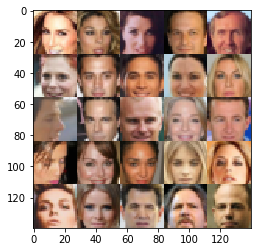

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

C:\Users\Dhruv Patel\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Batch 10... Discriminator Loss: 0.6631... Generator Loss: 2.2165
Epoch 1/2... Batch 20... Discriminator Loss: 0.5607... Generator Loss: 2.2825
Epoch 1/2... Batch 30... Discriminator Loss: 2.1810... Generator Loss: 13.7583
Epoch 1/2... Batch 40... Discriminator Loss: 0.6368... Generator Loss: 2.4528
Epoch 1/2... Batch 50... Discriminator Loss: 0.5602... Generator Loss: 2.7063
Epoch 1/2... Batch 60... Discriminator Loss: 0.6624... Generator Loss: 2.8951
Epoch 1/2... Batch 70... Discriminator Loss: 0.9976... Generator Loss: 1.2906
Epoch 1/2... Batch 80... Discriminator Loss: 1.1675... Generator Loss: 1.1094
Epoch 1/2... Batch 90... Discriminator Loss: 1.0456... Generator Loss: 1.7726
Epoch 1/2... Batch 100... Discriminator Loss: 1.0176... Generator Loss: 1.9247


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Batch 110... Discriminator Loss: 1.4011... Generator Loss: 2.0005
Epoch 1/2... Batch 120... Discriminator Loss: 1.1981... Generator Loss: 0.9571
Epoch 1/2... Batch 130... Discriminator Loss: 1.4552... Generator Loss: 2.1256
Epoch 1/2... Batch 140... Discriminator Loss: 1.4579... Generator Loss: 0.5630
Epoch 1/2... Batch 150... Discriminator Loss: 1.2281... Generator Loss: 1.6924
Epoch 1/2... Batch 160... Discriminator Loss: 1.4595... Generator Loss: 1.3066
Epoch 1/2... Batch 170... Discriminator Loss: 1.1351... Generator Loss: 1.0102
Epoch 1/2... Batch 180... Discriminator Loss: 1.0977... Generator Loss: 0.9277
Epoch 1/2... Batch 190... Discriminator Loss: 1.1916... Generator Loss: 0.9280
Epoch 1/2... Batch 200... Discriminator Loss: 1.2009... Generator Loss: 1.0423


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Batch 210... Discriminator Loss: 1.4085... Generator Loss: 1.8407
Epoch 1/2... Batch 220... Discriminator Loss: 1.1277... Generator Loss: 1.0898
Epoch 1/2... Batch 230... Discriminator Loss: 1.5038... Generator Loss: 0.4519
Epoch 1/2... Batch 240... Discriminator Loss: 1.1496... Generator Loss: 0.9753
Epoch 1/2... Batch 250... Discriminator Loss: 1.1680... Generator Loss: 1.6955
Epoch 1/2... Batch 260... Discriminator Loss: 1.1423... Generator Loss: 0.9493
Epoch 1/2... Batch 270... Discriminator Loss: 1.1497... Generator Loss: 0.9744
Epoch 1/2... Batch 280... Discriminator Loss: 1.1725... Generator Loss: 0.8074
Epoch 1/2... Batch 290... Discriminator Loss: 1.1005... Generator Loss: 1.1062
Epoch 1/2... Batch 300... Discriminator Loss: 1.3135... Generator Loss: 0.6400


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Batch 310... Discriminator Loss: 1.0737... Generator Loss: 0.9943
Epoch 1/2... Batch 320... Discriminator Loss: 1.1723... Generator Loss: 0.9123
Epoch 1/2... Batch 330... Discriminator Loss: 1.2269... Generator Loss: 1.0283
Epoch 1/2... Batch 340... Discriminator Loss: 1.2278... Generator Loss: 0.9448
Epoch 1/2... Batch 350... Discriminator Loss: 1.1959... Generator Loss: 1.4429
Epoch 1/2... Batch 360... Discriminator Loss: 1.3384... Generator Loss: 0.6911
Epoch 1/2... Batch 370... Discriminator Loss: 1.2690... Generator Loss: 1.6984
Epoch 1/2... Batch 380... Discriminator Loss: 1.0107... Generator Loss: 1.1516
Epoch 1/2... Batch 390... Discriminator Loss: 1.1916... Generator Loss: 1.2358
Epoch 1/2... Batch 400... Discriminator Loss: 1.2313... Generator Loss: 0.8397


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Batch 410... Discriminator Loss: 1.1016... Generator Loss: 1.2698
Epoch 1/2... Batch 420... Discriminator Loss: 0.9623... Generator Loss: 1.5556
Epoch 1/2... Batch 430... Discriminator Loss: 1.1988... Generator Loss: 1.5176
Epoch 1/2... Batch 440... Discriminator Loss: 1.0786... Generator Loss: 0.9968
Epoch 1/2... Batch 450... Discriminator Loss: 1.2147... Generator Loss: 1.2024
Epoch 1/2... Batch 460... Discriminator Loss: 1.1334... Generator Loss: 0.9149
Epoch 2/2... Batch 10... Discriminator Loss: 1.1968... Generator Loss: 0.8318
Epoch 2/2... Batch 20... Discriminator Loss: 1.1344... Generator Loss: 0.9765
Epoch 2/2... Batch 30... Discriminator Loss: 1.7360... Generator Loss: 2.0859
Epoch 2/2... Batch 40... Discriminator Loss: 1.2918... Generator Loss: 0.6333
Epoch 2/2... Batch 50... Discriminator Loss: 1.6593... Generator Loss: 0.3813
Epoch 2/2... Batch 60... Discriminator Loss: 1.1427... Generator Loss: 0.8165
Epoch 2/2... Batch 70... Discriminator Loss: 1.6390... Gen

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Batch 110... Discriminator Loss: 1.6229... Generator Loss: 2.2626
Epoch 2/2... Batch 120... Discriminator Loss: 1.3231... Generator Loss: 0.6022
Epoch 2/2... Batch 130... Discriminator Loss: 1.2316... Generator Loss: 0.6407
Epoch 2/2... Batch 140... Discriminator Loss: 1.4985... Generator Loss: 0.4738
Epoch 2/2... Batch 150... Discriminator Loss: 1.1407... Generator Loss: 1.0636
Epoch 2/2... Batch 160... Discriminator Loss: 1.4028... Generator Loss: 0.5979
Epoch 2/2... Batch 170... Discriminator Loss: 1.2231... Generator Loss: 0.7577
Epoch 2/2... Batch 180... Discriminator Loss: 1.0511... Generator Loss: 1.6710
Epoch 2/2... Batch 190... Discriminator Loss: 1.0328... Generator Loss: 0.9458
Epoch 2/2... Batch 200... Discriminator Loss: 1.4357... Generator Loss: 1.4539


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Batch 210... Discriminator Loss: 1.1876... Generator Loss: 0.6913
Epoch 2/2... Batch 220... Discriminator Loss: 1.0449... Generator Loss: 1.1561
Epoch 2/2... Batch 230... Discriminator Loss: 1.1911... Generator Loss: 0.7921
Epoch 2/2... Batch 240... Discriminator Loss: 1.2409... Generator Loss: 0.6787
Epoch 2/2... Batch 250... Discriminator Loss: 1.0729... Generator Loss: 1.1323
Epoch 2/2... Batch 260... Discriminator Loss: 1.2109... Generator Loss: 0.8066
Epoch 2/2... Batch 270... Discriminator Loss: 1.0943... Generator Loss: 1.4536
Epoch 2/2... Batch 280... Discriminator Loss: 1.1047... Generator Loss: 1.1527
Epoch 2/2... Batch 290... Discriminator Loss: 1.1640... Generator Loss: 1.6582
Epoch 2/2... Batch 300... Discriminator Loss: 1.1861... Generator Loss: 0.7283


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Batch 310... Discriminator Loss: 1.6019... Generator Loss: 0.4452
Epoch 2/2... Batch 320... Discriminator Loss: 1.0914... Generator Loss: 0.9513
Epoch 2/2... Batch 330... Discriminator Loss: 1.1842... Generator Loss: 1.9763
Epoch 2/2... Batch 340... Discriminator Loss: 1.1570... Generator Loss: 1.0325
Epoch 2/2... Batch 350... Discriminator Loss: 1.3491... Generator Loss: 1.7483
Epoch 2/2... Batch 360... Discriminator Loss: 1.2468... Generator Loss: 0.6558
Epoch 2/2... Batch 370... Discriminator Loss: 1.3138... Generator Loss: 1.7108
Epoch 2/2... Batch 380... Discriminator Loss: 1.2263... Generator Loss: 0.7496
Epoch 2/2... Batch 390... Discriminator Loss: 1.5658... Generator Loss: 0.4039
Epoch 2/2... Batch 400... Discriminator Loss: 1.0558... Generator Loss: 0.8844


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Batch 410... Discriminator Loss: 1.0887... Generator Loss: 1.0982
Epoch 2/2... Batch 420... Discriminator Loss: 0.9075... Generator Loss: 1.0335
Epoch 2/2... Batch 430... Discriminator Loss: 1.1014... Generator Loss: 1.1140
Epoch 2/2... Batch 440... Discriminator Loss: 1.1646... Generator Loss: 0.8600
Epoch 2/2... Batch 450... Discriminator Loss: 1.2843... Generator Loss: 0.6064
Epoch 2/2... Batch 460... Discriminator Loss: 1.1459... Generator Loss: 0.7658


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.6573... Generator Loss: 0.4554
Epoch 1/1... Batch 20... Discriminator Loss: 1.0039... Generator Loss: 0.8958
Epoch 1/1... Batch 30... Discriminator Loss: 0.8480... Generator Loss: 1.1925
Epoch 1/1... Batch 40... Discriminator Loss: 0.6542... Generator Loss: 1.7682
Epoch 1/1... Batch 50... Discriminator Loss: 0.7934... Generator Loss: 1.3020
Epoch 1/1... Batch 60... Discriminator Loss: 0.5927... Generator Loss: 2.4339
Epoch 1/1... Batch 70... Discriminator Loss: 0.4884... Generator Loss: 3.0274
Epoch 1/1... Batch 80... Discriminator Loss: 0.6390... Generator Loss: 1.8266
Epoch 1/1... Batch 90... Discriminator Loss: 0.4831... Generator Loss: 3.2647
Epoch 1/1... Batch 100... Discriminator Loss: 0.5338... Generator Loss: 2.4006


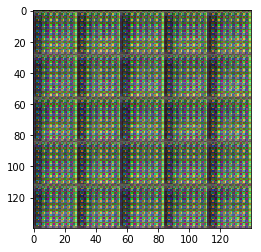

Epoch 1/1... Batch 110... Discriminator Loss: 0.8265... Generator Loss: 1.1977
Epoch 1/1... Batch 120... Discriminator Loss: 0.4360... Generator Loss: 3.4971
Epoch 1/1... Batch 130... Discriminator Loss: 0.4904... Generator Loss: 2.4601
Epoch 1/1... Batch 140... Discriminator Loss: 0.4823... Generator Loss: 2.5876
Epoch 1/1... Batch 150... Discriminator Loss: 0.5120... Generator Loss: 2.6768
Epoch 1/1... Batch 160... Discriminator Loss: 0.6961... Generator Loss: 1.4690
Epoch 1/1... Batch 170... Discriminator Loss: 0.5769... Generator Loss: 3.1883
Epoch 1/1... Batch 180... Discriminator Loss: 0.7558... Generator Loss: 1.3391
Epoch 1/1... Batch 190... Discriminator Loss: 0.6896... Generator Loss: 1.5085
Epoch 1/1... Batch 200... Discriminator Loss: 0.6400... Generator Loss: 1.9724


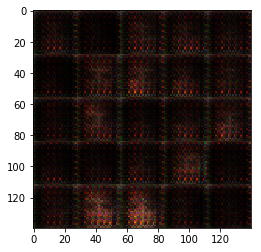

Epoch 1/1... Batch 210... Discriminator Loss: 0.7731... Generator Loss: 1.4613
Epoch 1/1... Batch 220... Discriminator Loss: 1.0227... Generator Loss: 0.8783
Epoch 1/1... Batch 230... Discriminator Loss: 0.5904... Generator Loss: 2.3348
Epoch 1/1... Batch 240... Discriminator Loss: 1.1063... Generator Loss: 0.8050
Epoch 1/1... Batch 250... Discriminator Loss: 0.7245... Generator Loss: 1.6609
Epoch 1/1... Batch 260... Discriminator Loss: 0.7719... Generator Loss: 2.3305
Epoch 1/1... Batch 270... Discriminator Loss: 0.9701... Generator Loss: 1.0529
Epoch 1/1... Batch 280... Discriminator Loss: 0.7713... Generator Loss: 1.6041
Epoch 1/1... Batch 290... Discriminator Loss: 0.8541... Generator Loss: 1.1609
Epoch 1/1... Batch 300... Discriminator Loss: 0.8451... Generator Loss: 1.4469


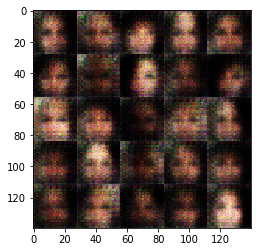

Epoch 1/1... Batch 310... Discriminator Loss: 0.8342... Generator Loss: 1.9164
Epoch 1/1... Batch 320... Discriminator Loss: 0.7510... Generator Loss: 1.9490
Epoch 1/1... Batch 330... Discriminator Loss: 1.0433... Generator Loss: 2.1506
Epoch 1/1... Batch 340... Discriminator Loss: 0.8965... Generator Loss: 1.1221
Epoch 1/1... Batch 350... Discriminator Loss: 1.0358... Generator Loss: 2.7873
Epoch 1/1... Batch 360... Discriminator Loss: 0.9142... Generator Loss: 1.2050
Epoch 1/1... Batch 370... Discriminator Loss: 0.8849... Generator Loss: 1.3072
Epoch 1/1... Batch 380... Discriminator Loss: 0.8753... Generator Loss: 1.2758
Epoch 1/1... Batch 390... Discriminator Loss: 0.9833... Generator Loss: 0.9625
Epoch 1/1... Batch 400... Discriminator Loss: 1.1508... Generator Loss: 1.0354


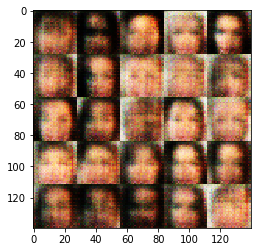

Epoch 1/1... Batch 410... Discriminator Loss: 0.9290... Generator Loss: 1.2610
Epoch 1/1... Batch 420... Discriminator Loss: 1.3032... Generator Loss: 2.7135
Epoch 1/1... Batch 430... Discriminator Loss: 0.8725... Generator Loss: 1.3105
Epoch 1/1... Batch 440... Discriminator Loss: 0.8421... Generator Loss: 1.2536
Epoch 1/1... Batch 450... Discriminator Loss: 1.0541... Generator Loss: 1.7024
Epoch 1/1... Batch 460... Discriminator Loss: 0.8643... Generator Loss: 1.3133
Epoch 1/1... Batch 470... Discriminator Loss: 0.8068... Generator Loss: 1.4738
Epoch 1/1... Batch 480... Discriminator Loss: 0.9703... Generator Loss: 1.4769
Epoch 1/1... Batch 490... Discriminator Loss: 0.8863... Generator Loss: 1.4334
Epoch 1/1... Batch 500... Discriminator Loss: 0.7831... Generator Loss: 1.8524


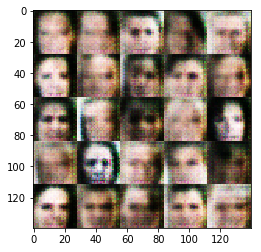

Epoch 1/1... Batch 510... Discriminator Loss: 0.8900... Generator Loss: 1.5937
Epoch 1/1... Batch 520... Discriminator Loss: 1.2433... Generator Loss: 0.8835
Epoch 1/1... Batch 530... Discriminator Loss: 1.0612... Generator Loss: 1.0857
Epoch 1/1... Batch 540... Discriminator Loss: 1.1674... Generator Loss: 0.9625
Epoch 1/1... Batch 550... Discriminator Loss: 0.9043... Generator Loss: 1.2237
Epoch 1/1... Batch 560... Discriminator Loss: 0.5952... Generator Loss: 1.9952
Epoch 1/1... Batch 570... Discriminator Loss: 1.0376... Generator Loss: 1.6422
Epoch 1/1... Batch 580... Discriminator Loss: 1.3026... Generator Loss: 0.6709
Epoch 1/1... Batch 590... Discriminator Loss: 0.9053... Generator Loss: 2.0304
Epoch 1/1... Batch 600... Discriminator Loss: 1.0967... Generator Loss: 2.2816


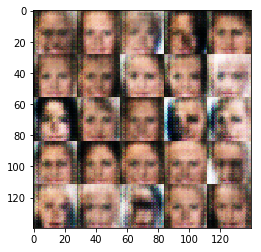

Epoch 1/1... Batch 610... Discriminator Loss: 0.8118... Generator Loss: 1.7449
Epoch 1/1... Batch 620... Discriminator Loss: 1.1263... Generator Loss: 0.9803
Epoch 1/1... Batch 630... Discriminator Loss: 1.3535... Generator Loss: 0.6756
Epoch 1/1... Batch 640... Discriminator Loss: 1.1442... Generator Loss: 1.6665
Epoch 1/1... Batch 650... Discriminator Loss: 1.4200... Generator Loss: 2.3626
Epoch 1/1... Batch 660... Discriminator Loss: 1.0111... Generator Loss: 1.1586
Epoch 1/1... Batch 670... Discriminator Loss: 1.0262... Generator Loss: 1.4983
Epoch 1/1... Batch 680... Discriminator Loss: 1.0623... Generator Loss: 1.2600
Epoch 1/1... Batch 690... Discriminator Loss: 1.1128... Generator Loss: 1.6737
Epoch 1/1... Batch 700... Discriminator Loss: 1.0149... Generator Loss: 1.4726


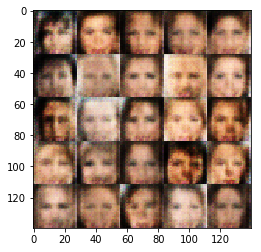

Epoch 1/1... Batch 710... Discriminator Loss: 1.1105... Generator Loss: 1.0490
Epoch 1/1... Batch 720... Discriminator Loss: 0.9852... Generator Loss: 1.2449
Epoch 1/1... Batch 730... Discriminator Loss: 1.0731... Generator Loss: 0.9809
Epoch 1/1... Batch 740... Discriminator Loss: 1.1620... Generator Loss: 0.8640
Epoch 1/1... Batch 750... Discriminator Loss: 1.1111... Generator Loss: 1.0491
Epoch 1/1... Batch 760... Discriminator Loss: 0.9406... Generator Loss: 1.6022
Epoch 1/1... Batch 770... Discriminator Loss: 0.9894... Generator Loss: 1.4467
Epoch 1/1... Batch 780... Discriminator Loss: 0.9828... Generator Loss: 1.5034
Epoch 1/1... Batch 790... Discriminator Loss: 1.0740... Generator Loss: 1.3629
Epoch 1/1... Batch 800... Discriminator Loss: 1.0215... Generator Loss: 0.9933


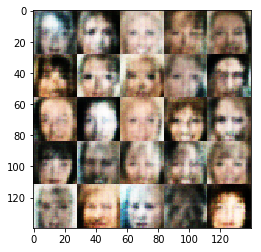

Epoch 1/1... Batch 810... Discriminator Loss: 1.2163... Generator Loss: 0.7767
Epoch 1/1... Batch 820... Discriminator Loss: 1.1956... Generator Loss: 0.8169
Epoch 1/1... Batch 830... Discriminator Loss: 1.1907... Generator Loss: 0.8173
Epoch 1/1... Batch 840... Discriminator Loss: 1.0018... Generator Loss: 1.0316
Epoch 1/1... Batch 850... Discriminator Loss: 0.9921... Generator Loss: 1.7351
Epoch 1/1... Batch 860... Discriminator Loss: 1.0741... Generator Loss: 1.0781
Epoch 1/1... Batch 870... Discriminator Loss: 0.9683... Generator Loss: 1.3820
Epoch 1/1... Batch 880... Discriminator Loss: 1.1879... Generator Loss: 0.7343
Epoch 1/1... Batch 890... Discriminator Loss: 1.1851... Generator Loss: 0.9675
Epoch 1/1... Batch 900... Discriminator Loss: 1.0943... Generator Loss: 0.9357


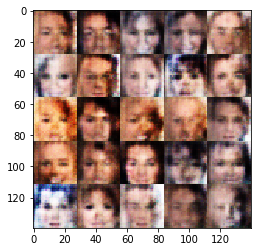

Epoch 1/1... Batch 910... Discriminator Loss: 1.1762... Generator Loss: 1.2612
Epoch 1/1... Batch 920... Discriminator Loss: 1.3549... Generator Loss: 1.4212
Epoch 1/1... Batch 930... Discriminator Loss: 1.0187... Generator Loss: 1.3530
Epoch 1/1... Batch 940... Discriminator Loss: 1.0892... Generator Loss: 1.5460
Epoch 1/1... Batch 950... Discriminator Loss: 1.0291... Generator Loss: 1.1116
Epoch 1/1... Batch 960... Discriminator Loss: 1.1726... Generator Loss: 1.2948
Epoch 1/1... Batch 970... Discriminator Loss: 1.0196... Generator Loss: 1.1451
Epoch 1/1... Batch 980... Discriminator Loss: 1.1987... Generator Loss: 0.6790
Epoch 1/1... Batch 990... Discriminator Loss: 0.9977... Generator Loss: 1.4408
Epoch 1/1... Batch 1000... Discriminator Loss: 0.9127... Generator Loss: 1.3224


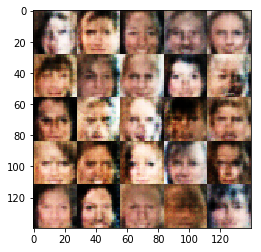

Epoch 1/1... Batch 1010... Discriminator Loss: 1.0498... Generator Loss: 0.9739
Epoch 1/1... Batch 1020... Discriminator Loss: 1.1761... Generator Loss: 0.6851
Epoch 1/1... Batch 1030... Discriminator Loss: 0.9468... Generator Loss: 1.4286
Epoch 1/1... Batch 1040... Discriminator Loss: 1.0470... Generator Loss: 1.7624
Epoch 1/1... Batch 1050... Discriminator Loss: 1.1736... Generator Loss: 1.8385
Epoch 1/1... Batch 1060... Discriminator Loss: 1.0137... Generator Loss: 0.9527
Epoch 1/1... Batch 1070... Discriminator Loss: 1.1471... Generator Loss: 0.6860
Epoch 1/1... Batch 1080... Discriminator Loss: 1.0368... Generator Loss: 0.9344
Epoch 1/1... Batch 1090... Discriminator Loss: 0.9637... Generator Loss: 1.2063
Epoch 1/1... Batch 1100... Discriminator Loss: 1.2606... Generator Loss: 0.6243


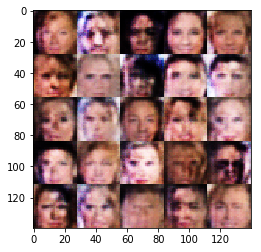

Epoch 1/1... Batch 1110... Discriminator Loss: 1.1154... Generator Loss: 1.0409
Epoch 1/1... Batch 1120... Discriminator Loss: 1.1281... Generator Loss: 1.2751
Epoch 1/1... Batch 1130... Discriminator Loss: 1.0978... Generator Loss: 0.8588
Epoch 1/1... Batch 1140... Discriminator Loss: 1.0965... Generator Loss: 1.0095
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1232... Generator Loss: 0.7690
Epoch 1/1... Batch 1160... Discriminator Loss: 1.0377... Generator Loss: 0.9990
Epoch 1/1... Batch 1170... Discriminator Loss: 1.1230... Generator Loss: 0.9587
Epoch 1/1... Batch 1180... Discriminator Loss: 1.1620... Generator Loss: 0.9929
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1107... Generator Loss: 0.9227
Epoch 1/1... Batch 1200... Discriminator Loss: 0.8679... Generator Loss: 1.5555


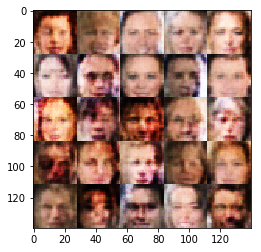

Epoch 1/1... Batch 1210... Discriminator Loss: 1.2199... Generator Loss: 0.8869
Epoch 1/1... Batch 1220... Discriminator Loss: 1.1866... Generator Loss: 0.8227
Epoch 1/1... Batch 1230... Discriminator Loss: 0.9490... Generator Loss: 1.2247
Epoch 1/1... Batch 1240... Discriminator Loss: 1.0741... Generator Loss: 1.3115
Epoch 1/1... Batch 1250... Discriminator Loss: 1.1425... Generator Loss: 0.9439
Epoch 1/1... Batch 1260... Discriminator Loss: 1.1880... Generator Loss: 1.1756
Epoch 1/1... Batch 1270... Discriminator Loss: 0.9649... Generator Loss: 1.1848
Epoch 1/1... Batch 1280... Discriminator Loss: 1.1733... Generator Loss: 0.7147
Epoch 1/1... Batch 1290... Discriminator Loss: 0.9474... Generator Loss: 1.9443
Epoch 1/1... Batch 1300... Discriminator Loss: 1.0874... Generator Loss: 1.0469


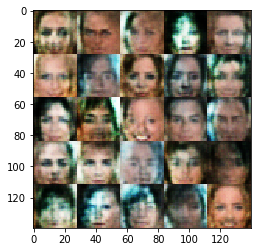

Epoch 1/1... Batch 1310... Discriminator Loss: 0.9961... Generator Loss: 1.1872
Epoch 1/1... Batch 1320... Discriminator Loss: 1.1381... Generator Loss: 0.8672
Epoch 1/1... Batch 1330... Discriminator Loss: 1.1540... Generator Loss: 1.4616
Epoch 1/1... Batch 1340... Discriminator Loss: 1.1183... Generator Loss: 0.9579
Epoch 1/1... Batch 1350... Discriminator Loss: 1.2169... Generator Loss: 0.6698
Epoch 1/1... Batch 1360... Discriminator Loss: 1.0906... Generator Loss: 1.4746
Epoch 1/1... Batch 1370... Discriminator Loss: 1.1658... Generator Loss: 0.8376
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2744... Generator Loss: 0.7431
Epoch 1/1... Batch 1390... Discriminator Loss: 1.0940... Generator Loss: 1.3119
Epoch 1/1... Batch 1400... Discriminator Loss: 0.8545... Generator Loss: 1.5463


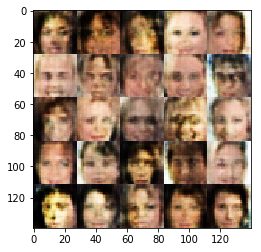

Epoch 1/1... Batch 1410... Discriminator Loss: 1.1034... Generator Loss: 1.1381
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0827... Generator Loss: 1.0408
Epoch 1/1... Batch 1430... Discriminator Loss: 1.3798... Generator Loss: 0.7041
Epoch 1/1... Batch 1440... Discriminator Loss: 1.1463... Generator Loss: 0.8287
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2250... Generator Loss: 0.8380
Epoch 1/1... Batch 1460... Discriminator Loss: 1.1160... Generator Loss: 1.0443
Epoch 1/1... Batch 1470... Discriminator Loss: 1.0426... Generator Loss: 1.1876
Epoch 1/1... Batch 1480... Discriminator Loss: 1.2074... Generator Loss: 0.8436
Epoch 1/1... Batch 1490... Discriminator Loss: 1.2299... Generator Loss: 0.8314
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2302... Generator Loss: 0.7739


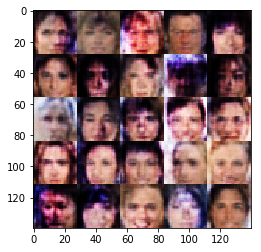

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2406... Generator Loss: 0.9753
Epoch 1/1... Batch 1520... Discriminator Loss: 1.1180... Generator Loss: 0.9224
Epoch 1/1... Batch 1530... Discriminator Loss: 1.0173... Generator Loss: 1.0241
Epoch 1/1... Batch 1540... Discriminator Loss: 1.0779... Generator Loss: 1.0578
Epoch 1/1... Batch 1550... Discriminator Loss: 1.1483... Generator Loss: 1.0896
Epoch 1/1... Batch 1560... Discriminator Loss: 1.1667... Generator Loss: 0.8679
Epoch 1/1... Batch 1570... Discriminator Loss: 1.1598... Generator Loss: 0.9421
Epoch 1/1... Batch 1580... Discriminator Loss: 1.0361... Generator Loss: 1.0271
Epoch 1/1... Batch 1590... Discriminator Loss: 1.0518... Generator Loss: 1.2257
Epoch 1/1... Batch 1600... Discriminator Loss: 1.0876... Generator Loss: 1.4496


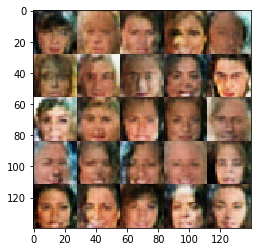

Epoch 1/1... Batch 1610... Discriminator Loss: 1.0722... Generator Loss: 1.1715
Epoch 1/1... Batch 1620... Discriminator Loss: 1.1158... Generator Loss: 1.2476
Epoch 1/1... Batch 1630... Discriminator Loss: 1.1152... Generator Loss: 0.9588
Epoch 1/1... Batch 1640... Discriminator Loss: 1.2522... Generator Loss: 0.7115
Epoch 1/1... Batch 1650... Discriminator Loss: 1.1929... Generator Loss: 0.7090
Epoch 1/1... Batch 1660... Discriminator Loss: 1.1640... Generator Loss: 0.9963
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2469... Generator Loss: 0.7260
Epoch 1/1... Batch 1680... Discriminator Loss: 1.2419... Generator Loss: 0.7713
Epoch 1/1... Batch 1690... Discriminator Loss: 1.1199... Generator Loss: 1.0067
Epoch 1/1... Batch 1700... Discriminator Loss: 1.1044... Generator Loss: 0.9312


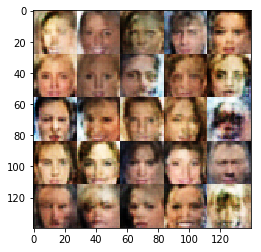

Epoch 1/1... Batch 1710... Discriminator Loss: 1.1058... Generator Loss: 0.7939
Epoch 1/1... Batch 1720... Discriminator Loss: 1.1949... Generator Loss: 0.9617
Epoch 1/1... Batch 1730... Discriminator Loss: 0.9992... Generator Loss: 1.4811
Epoch 1/1... Batch 1740... Discriminator Loss: 1.0662... Generator Loss: 1.1527
Epoch 1/1... Batch 1750... Discriminator Loss: 1.1020... Generator Loss: 0.9809
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1273... Generator Loss: 1.1299
Epoch 1/1... Batch 1770... Discriminator Loss: 1.0945... Generator Loss: 1.0316
Epoch 1/1... Batch 1780... Discriminator Loss: 1.1821... Generator Loss: 1.1248
Epoch 1/1... Batch 1790... Discriminator Loss: 1.1587... Generator Loss: 0.9967
Epoch 1/1... Batch 1800... Discriminator Loss: 1.0762... Generator Loss: 0.9775


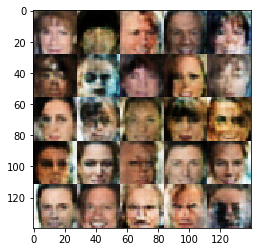

Epoch 1/1... Batch 1810... Discriminator Loss: 1.0631... Generator Loss: 1.0346
Epoch 1/1... Batch 1820... Discriminator Loss: 1.0843... Generator Loss: 1.0240
Epoch 1/1... Batch 1830... Discriminator Loss: 0.9795... Generator Loss: 1.2185
Epoch 1/1... Batch 1840... Discriminator Loss: 1.2266... Generator Loss: 0.7926
Epoch 1/1... Batch 1850... Discriminator Loss: 1.2382... Generator Loss: 0.6799
Epoch 1/1... Batch 1860... Discriminator Loss: 1.1676... Generator Loss: 1.0380
Epoch 1/1... Batch 1870... Discriminator Loss: 1.4580... Generator Loss: 0.5300
Epoch 1/1... Batch 1880... Discriminator Loss: 1.1892... Generator Loss: 0.9669
Epoch 1/1... Batch 1890... Discriminator Loss: 1.0945... Generator Loss: 1.0508
Epoch 1/1... Batch 1900... Discriminator Loss: 1.2213... Generator Loss: 0.9314


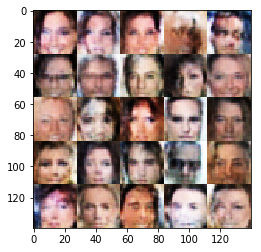

Epoch 1/1... Batch 1910... Discriminator Loss: 1.1293... Generator Loss: 0.8721
Epoch 1/1... Batch 1920... Discriminator Loss: 1.4185... Generator Loss: 0.6031
Epoch 1/1... Batch 1930... Discriminator Loss: 1.2013... Generator Loss: 0.7807
Epoch 1/1... Batch 1940... Discriminator Loss: 1.1723... Generator Loss: 0.9325
Epoch 1/1... Batch 1950... Discriminator Loss: 1.1582... Generator Loss: 0.8992
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1172... Generator Loss: 1.1259
Epoch 1/1... Batch 1970... Discriminator Loss: 1.1995... Generator Loss: 0.7619
Epoch 1/1... Batch 1980... Discriminator Loss: 1.0476... Generator Loss: 0.8310
Epoch 1/1... Batch 1990... Discriminator Loss: 1.2495... Generator Loss: 0.6892
Epoch 1/1... Batch 2000... Discriminator Loss: 1.2085... Generator Loss: 0.8500


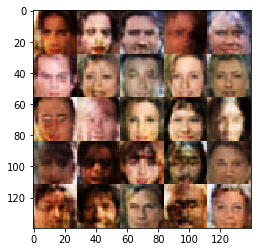

Epoch 1/1... Batch 2010... Discriminator Loss: 1.2949... Generator Loss: 0.6844
Epoch 1/1... Batch 2020... Discriminator Loss: 1.2296... Generator Loss: 0.8748
Epoch 1/1... Batch 2030... Discriminator Loss: 1.1770... Generator Loss: 1.0512
Epoch 1/1... Batch 2040... Discriminator Loss: 1.2491... Generator Loss: 0.7133
Epoch 1/1... Batch 2050... Discriminator Loss: 0.9662... Generator Loss: 1.0772
Epoch 1/1... Batch 2060... Discriminator Loss: 1.2374... Generator Loss: 0.7215
Epoch 1/1... Batch 2070... Discriminator Loss: 1.2126... Generator Loss: 0.6881
Epoch 1/1... Batch 2080... Discriminator Loss: 1.2667... Generator Loss: 0.6847
Epoch 1/1... Batch 2090... Discriminator Loss: 1.4169... Generator Loss: 0.5697
Epoch 1/1... Batch 2100... Discriminator Loss: 1.2873... Generator Loss: 0.8947


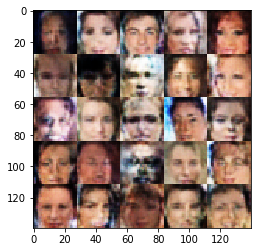

Epoch 1/1... Batch 2110... Discriminator Loss: 1.2046... Generator Loss: 1.0822
Epoch 1/1... Batch 2120... Discriminator Loss: 1.2172... Generator Loss: 0.7475
Epoch 1/1... Batch 2130... Discriminator Loss: 1.0851... Generator Loss: 0.8860
Epoch 1/1... Batch 2140... Discriminator Loss: 1.2141... Generator Loss: 0.9180
Epoch 1/1... Batch 2150... Discriminator Loss: 1.3203... Generator Loss: 0.6306
Epoch 1/1... Batch 2160... Discriminator Loss: 1.4649... Generator Loss: 0.5180
Epoch 1/1... Batch 2170... Discriminator Loss: 1.0596... Generator Loss: 1.2468
Epoch 1/1... Batch 2180... Discriminator Loss: 1.2129... Generator Loss: 0.8709
Epoch 1/1... Batch 2190... Discriminator Loss: 1.2653... Generator Loss: 0.8059
Epoch 1/1... Batch 2200... Discriminator Loss: 1.1005... Generator Loss: 0.9515


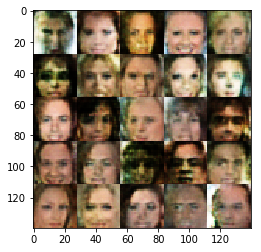

Epoch 1/1... Batch 2210... Discriminator Loss: 1.1301... Generator Loss: 1.0589
Epoch 1/1... Batch 2220... Discriminator Loss: 1.0876... Generator Loss: 0.8086
Epoch 1/1... Batch 2230... Discriminator Loss: 1.3466... Generator Loss: 1.0641
Epoch 1/1... Batch 2240... Discriminator Loss: 1.0905... Generator Loss: 0.8684
Epoch 1/1... Batch 2250... Discriminator Loss: 1.1376... Generator Loss: 0.9842
Epoch 1/1... Batch 2260... Discriminator Loss: 1.0686... Generator Loss: 1.0246
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2161... Generator Loss: 0.6855
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2563... Generator Loss: 0.7167
Epoch 1/1... Batch 2290... Discriminator Loss: 0.9748... Generator Loss: 0.9763
Epoch 1/1... Batch 2300... Discriminator Loss: 0.9542... Generator Loss: 1.1383


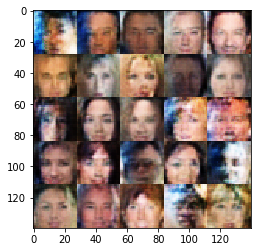

Epoch 1/1... Batch 2310... Discriminator Loss: 1.1457... Generator Loss: 0.9130
Epoch 1/1... Batch 2320... Discriminator Loss: 1.2374... Generator Loss: 0.9098
Epoch 1/1... Batch 2330... Discriminator Loss: 1.1189... Generator Loss: 0.9554
Epoch 1/1... Batch 2340... Discriminator Loss: 1.1422... Generator Loss: 0.7647
Epoch 1/1... Batch 2350... Discriminator Loss: 1.3697... Generator Loss: 0.6182
Epoch 1/1... Batch 2360... Discriminator Loss: 1.0958... Generator Loss: 0.9961
Epoch 1/1... Batch 2370... Discriminator Loss: 1.1916... Generator Loss: 0.7729
Epoch 1/1... Batch 2380... Discriminator Loss: 1.1741... Generator Loss: 1.0037
Epoch 1/1... Batch 2390... Discriminator Loss: 0.9793... Generator Loss: 1.0357
Epoch 1/1... Batch 2400... Discriminator Loss: 1.0351... Generator Loss: 0.9418


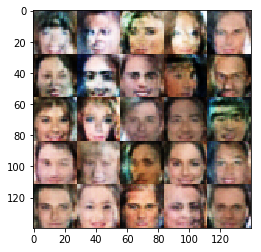

Epoch 1/1... Batch 2410... Discriminator Loss: 1.2151... Generator Loss: 0.7774
Epoch 1/1... Batch 2420... Discriminator Loss: 1.1607... Generator Loss: 0.8806
Epoch 1/1... Batch 2430... Discriminator Loss: 0.9686... Generator Loss: 1.1901
Epoch 1/1... Batch 2440... Discriminator Loss: 1.1603... Generator Loss: 0.8420
Epoch 1/1... Batch 2450... Discriminator Loss: 1.1304... Generator Loss: 1.1537
Epoch 1/1... Batch 2460... Discriminator Loss: 1.1505... Generator Loss: 0.8421
Epoch 1/1... Batch 2470... Discriminator Loss: 1.1865... Generator Loss: 0.9055
Epoch 1/1... Batch 2480... Discriminator Loss: 0.9019... Generator Loss: 1.2878
Epoch 1/1... Batch 2490... Discriminator Loss: 1.1763... Generator Loss: 0.9131
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2285... Generator Loss: 0.7546


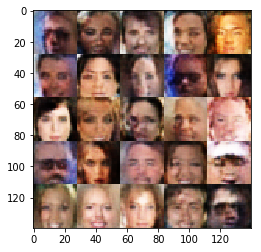

Epoch 1/1... Batch 2510... Discriminator Loss: 1.2294... Generator Loss: 0.8118
Epoch 1/1... Batch 2520... Discriminator Loss: 1.1815... Generator Loss: 0.8859
Epoch 1/1... Batch 2530... Discriminator Loss: 1.2671... Generator Loss: 0.8451
Epoch 1/1... Batch 2540... Discriminator Loss: 1.2509... Generator Loss: 0.7234
Epoch 1/1... Batch 2550... Discriminator Loss: 1.2535... Generator Loss: 0.8625
Epoch 1/1... Batch 2560... Discriminator Loss: 1.0372... Generator Loss: 1.0999
Epoch 1/1... Batch 2570... Discriminator Loss: 1.1673... Generator Loss: 0.7734
Epoch 1/1... Batch 2580... Discriminator Loss: 1.1761... Generator Loss: 0.8485
Epoch 1/1... Batch 2590... Discriminator Loss: 1.2207... Generator Loss: 0.8847
Epoch 1/1... Batch 2600... Discriminator Loss: 1.4154... Generator Loss: 0.5930


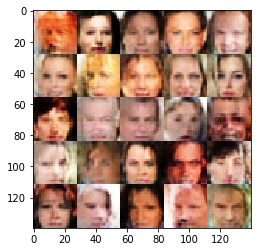

Epoch 1/1... Batch 2610... Discriminator Loss: 1.0470... Generator Loss: 1.1354
Epoch 1/1... Batch 2620... Discriminator Loss: 1.1766... Generator Loss: 0.9575
Epoch 1/1... Batch 2630... Discriminator Loss: 1.0607... Generator Loss: 1.0839
Epoch 1/1... Batch 2640... Discriminator Loss: 1.1736... Generator Loss: 0.8228
Epoch 1/1... Batch 2650... Discriminator Loss: 1.3140... Generator Loss: 0.6588
Epoch 1/1... Batch 2660... Discriminator Loss: 1.1628... Generator Loss: 1.1105
Epoch 1/1... Batch 2670... Discriminator Loss: 1.2776... Generator Loss: 0.6391
Epoch 1/1... Batch 2680... Discriminator Loss: 1.1899... Generator Loss: 0.7563
Epoch 1/1... Batch 2690... Discriminator Loss: 1.1918... Generator Loss: 0.8757
Epoch 1/1... Batch 2700... Discriminator Loss: 0.9816... Generator Loss: 1.0161


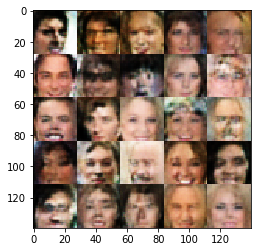

Epoch 1/1... Batch 2710... Discriminator Loss: 1.2314... Generator Loss: 0.7832
Epoch 1/1... Batch 2720... Discriminator Loss: 1.3078... Generator Loss: 0.6559
Epoch 1/1... Batch 2730... Discriminator Loss: 1.2655... Generator Loss: 0.7267
Epoch 1/1... Batch 2740... Discriminator Loss: 1.0719... Generator Loss: 0.9782
Epoch 1/1... Batch 2750... Discriminator Loss: 1.0078... Generator Loss: 1.0810
Epoch 1/1... Batch 2760... Discriminator Loss: 1.2264... Generator Loss: 0.8080
Epoch 1/1... Batch 2770... Discriminator Loss: 1.0303... Generator Loss: 1.0353
Epoch 1/1... Batch 2780... Discriminator Loss: 1.0526... Generator Loss: 1.2061
Epoch 1/1... Batch 2790... Discriminator Loss: 1.2881... Generator Loss: 0.7054
Epoch 1/1... Batch 2800... Discriminator Loss: 0.9977... Generator Loss: 1.1264


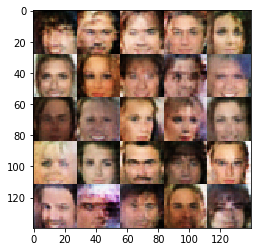

Epoch 1/1... Batch 2810... Discriminator Loss: 1.2969... Generator Loss: 1.0012
Epoch 1/1... Batch 2820... Discriminator Loss: 1.1024... Generator Loss: 0.9053
Epoch 1/1... Batch 2830... Discriminator Loss: 1.4005... Generator Loss: 0.5892
Epoch 1/1... Batch 2840... Discriminator Loss: 1.1809... Generator Loss: 0.8297
Epoch 1/1... Batch 2850... Discriminator Loss: 0.9363... Generator Loss: 1.3110
Epoch 1/1... Batch 2860... Discriminator Loss: 1.0848... Generator Loss: 1.1747
Epoch 1/1... Batch 2870... Discriminator Loss: 1.1554... Generator Loss: 0.8722
Epoch 1/1... Batch 2880... Discriminator Loss: 0.9981... Generator Loss: 1.0489
Epoch 1/1... Batch 2890... Discriminator Loss: 1.1060... Generator Loss: 0.9873
Epoch 1/1... Batch 2900... Discriminator Loss: 1.4429... Generator Loss: 0.6703


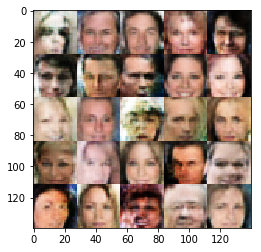

Epoch 1/1... Batch 2910... Discriminator Loss: 1.2042... Generator Loss: 0.8108
Epoch 1/1... Batch 2920... Discriminator Loss: 0.9803... Generator Loss: 0.9836
Epoch 1/1... Batch 2930... Discriminator Loss: 1.1504... Generator Loss: 0.8303
Epoch 1/1... Batch 2940... Discriminator Loss: 1.2933... Generator Loss: 0.6740
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2022... Generator Loss: 0.8953
Epoch 1/1... Batch 2960... Discriminator Loss: 1.0413... Generator Loss: 1.1683
Epoch 1/1... Batch 2970... Discriminator Loss: 1.1309... Generator Loss: 0.9570
Epoch 1/1... Batch 2980... Discriminator Loss: 1.1297... Generator Loss: 0.9361
Epoch 1/1... Batch 2990... Discriminator Loss: 1.1554... Generator Loss: 1.0252
Epoch 1/1... Batch 3000... Discriminator Loss: 1.2765... Generator Loss: 0.7217


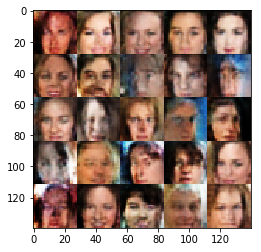

Epoch 1/1... Batch 3010... Discriminator Loss: 1.2140... Generator Loss: 0.8763
Epoch 1/1... Batch 3020... Discriminator Loss: 1.3107... Generator Loss: 0.7193
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3148... Generator Loss: 0.7134
Epoch 1/1... Batch 3040... Discriminator Loss: 1.5586... Generator Loss: 0.6029
Epoch 1/1... Batch 3050... Discriminator Loss: 1.2946... Generator Loss: 0.6011
Epoch 1/1... Batch 3060... Discriminator Loss: 1.0975... Generator Loss: 0.8467
Epoch 1/1... Batch 3070... Discriminator Loss: 0.9212... Generator Loss: 1.2752
Epoch 1/1... Batch 3080... Discriminator Loss: 1.1150... Generator Loss: 1.1430
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1086... Generator Loss: 0.9802
Epoch 1/1... Batch 3100... Discriminator Loss: 1.0511... Generator Loss: 1.0084


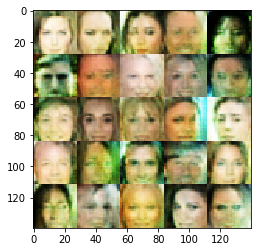

Epoch 1/1... Batch 3110... Discriminator Loss: 1.2764... Generator Loss: 0.7444
Epoch 1/1... Batch 3120... Discriminator Loss: 1.0979... Generator Loss: 1.0187
Epoch 1/1... Batch 3130... Discriminator Loss: 1.2453... Generator Loss: 0.7617
Epoch 1/1... Batch 3140... Discriminator Loss: 1.0393... Generator Loss: 1.1472
Epoch 1/1... Batch 3150... Discriminator Loss: 1.4042... Generator Loss: 0.5818
Epoch 1/1... Batch 3160... Discriminator Loss: 1.3582... Generator Loss: 0.5914


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.